In [1]:
from model_utils import *

In [2]:
FILE = "./data/filtered_elmundo.json"
DATASET_NAME = 'elmundo'
LOG_DIR = "./news-classification"
MAX_CATE_SIZE = 3000
MODEL_NAME = 'skimai/spanberta-base-cased'
MAX_SEQ_LENGTH = 128
BATCH_SIZE = 128

In [3]:
# classifier label set
target_label = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING',
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION',
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT',
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA',
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY',
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']
# source item label set
source_label = ['economia',  # economic
              'internacional',  # international
              'deportes',  # sports
              'cultura',  # culture
              'television',  # television
              'ciencia-y-salud',  # science and health
              'tecnologia',  # technology
               ]
source_label_dic = {}
for idx, label in enumerate(source_label):
    source_label_dic[label] = idx

## Load Data

In [4]:
def load_test_data(path,cate_size,type='JSON',percentage=1):
    if type == "JSON":
        df = pd.read_json(path)
    else:
        df = pd.read_csv(path)
    df = df.iloc[np.random.permutation(len(df))]
    df.describe()
    labels = df['category'].tolist()
    titles = df['title'].tolist()
    stand_first = df['stand_first'].tolist()
    contents = df['content'].tolist()
    contents = [h + s + d for h, s, d in zip(titles, stand_first, contents)]
    label_dic = {}
    final_size = int(len(contents) * percentage)
    if percentage != 1:
        contents = contents[:final_size]
        labels = labels[:final_size]

    # itos                                        
    label_set = ['WORLD NEWS', 'ARTS & CULTURE', 'WEDDINGS', 'PARENTING',
                 'BUSINESS & FINANCES', 'HOME & LIVING', 'EDUCATION',
                 'WELLNESS', 'POLITICS', 'WOMEN', 'IMPACT', 'ENVIRONMENT',
                 'SPORTS', 'FOOD & DRINK', 'GROUPS VOICES', 'MEDIA',
                 'SCIENCE & TECH', 'CRIME', 'WEIRD NEWS', 'COMEDY',
                 'RELIGION', 'MISCELLANEOUS', 'DIVORCE', 'ENTERTAINMENT',
                 'STYLE & BEAUTY', 'TRAVEL']
    # stoi
    for idx, label in enumerate(label_set):
        label_dic[label] = idx
    """
    label_count = {}
    flitered_labels = []
    flitered_contents = []
    for cate, cont in zip(labels, contents):
        if cate not in label_count.keys():
            label_count[cate] = 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
        elif label_count[cate] < cate_size:
            label_count[cate] += 1
            flitered_labels.append(cate)
            flitered_contents.append(cont)
    
    """
    # shuffle
    idx_list = list(range(0, len(labels), 1))
    random.shuffle(idx_list)
    shuffled_labels = []
    shuffled_contents = []
    for idp in idx_list:
        shuffled_labels.append(labels[idp])
        shuffled_contents.append(contents[idp])
    print('Data loaded label:{} content:{} '.format(len(labels), len(contents)))
    return shuffled_labels, shuffled_contents, label_set, label_dic

In [5]:
class TestDataset(Dataset):
    def __init__(self,labels,inputs,origins,ldic):
        self.labels = labels
        self.origins = origins
        self.inputs = inputs
        self.ldic = ldic
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self,idx):
        y = self.labels[idx]
        y_encoded = torch.Tensor([self.ldic.get(y,-1)]).long().squeeze(0)
        res ={
            'input_ids':self.inputs[idx]['input_ids'][0],
            'attention_mask': self.inputs[idx]['attention_mask'][0],
            'origin_contents':self.origins[idx],
            'targets':y_encoded,
        }
        return res

In [6]:
# load test data and label info
labels,contents,lset,ldic = load_test_data(FILE,MAX_CATE_SIZE,'JSON',1)

# encode
start = time.time()
encoding_list = pre_encode_list(MODEL_NAME,contents,MAX_SEQ_LENGTH)
print("encoding time costs: {}".format(time.time()-start))

# load valid dataset 
valid_dataset = TestDataset(labels,encoding_list,contents,source_label_dic)
print("data loaded \n {}".format(len(valid_dataset)))
      
# dataloader
loader = DataLoader(dataset=valid_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False)

Data loaded label:4520 content:4520 


100%|██████████| 4520/4520 [00:03<00:00, 1503.95it/s]

Tokenizer loaded...
encoding time costs: 8.134692907333374
data loaded 
 4520


In [7]:
if not os.path.exists('./{}-valid-results'.format(DATASET_NAME)):
    os.makedirs('./{}-valid-results'.format(DATASET_NAME))
if not os.path.exists('./{}-valid-results/{}'.format(DATASET_NAME, MAX_SEQ_LENGTH)):
    os.makedirs('./{}-valid-results/{}'.format(DATASET_NAME, MAX_SEQ_LENGTH))

In [8]:
#load model
model = RobertaForSequenceClassification(MODEL_NAME,len(lset))
state_dict = torch.load('./results/3.699999999999999e-05-128/5-18-epoch-4.pth')
model.load_state_dict(state_dict)
if torch.cuda.is_available():
    model = nn.DataParallel(model)
    model.cuda()

In [9]:
iterator = loader
true_labels = []
pred_labels = []

model.eval()
tkz = AutoTokenizer.from_pretrained(MODEL_NAME)
with torch.no_grad():
    for ba,data in enumerate(notetqdm(iterator)):
        features = data['input_ids'].cuda()
        att_mask = data['attention_mask'].cuda()
        targets = data['targets']
        targets.numpy()
        true_labels += targets.tolist()
        outputs = model(features,att_mask)
        outputs = outputs.cpu().detach().numpy()
        outputs = np.argmax(outputs, axis=1)
        # print screen 
        for i in range(len(data)):
            print(data['origin_contents'][i])
            print('pred: ',lset[outputs[i]])
            print('true: ',source_label[targets[i]])
            print('--------------')
        pred_labels += outputs.tolist()
    print(len(true_labels))
    print(true_labels[:15])
    print(len(pred_labels))
    print(pred_labels[:15])
        

  0%|          | 0/36 [00:00<?, ?it/s]

SailGP, la Fórmula 1 del mar: mismos peligros y velocidades que asustanCádiz acoge la novedosa competición entre los catamaranes más rápidos del planeta a 100 km/h.Cuando uno conduce por la autopista a 100 kilómetros por hora, se da cuenta de que las cosas van más rápido y que nada, ni nadie, se detiene. Se da por hecho que un vehículo a motor puede alcanzar cierta velocidad sin demasiado esfuerzo, pero traslad
pred:  WELLNESS
true:  deportes
--------------
El incremento de los precios se adelanta a la recuperación económica por el encarecimiento de la luz y los carburantesEl dato marca un fuerte cambio de tendencia tras las caídas de precios de 2020El incremento de los precios se adelanta a la recuperación de la economía. En marzo, el IPC que mide la evolución del coste de la cesta de la compra para los hogares registró un incremento del 1,3%, según ha publicado este martes el INE. Se trata del mayor aumento en comparativa anual desde abril de 2019 y, sobre todo, muestra ya una clara 

Atrapados en las reformas: "Si le das más de dos semanas de validez al presupuesto pierdes dinero"La escasez de materiales y los altos precios de los carburantes han disparado el precio de metales y maderas y, con ellos, el de las reformasA pesar de que en algunos casos la factura ha aumentado hasta un 45%, la subida del precio de la luz no es el único problema al que se enfrentan muchos pequeños empresarios. Según denuncian autónomos, asociaciones y clientes, el alto precio de los materiales ha hecho que se dispare también el de las reformas en un momento en el que la demanda sigue aumentando, lo que hace que los presupuestos queden obsoletos en cuestión de semanas.
pred:  BUSINESS & FINANCES
true:  economia
--------------
Cinco obras infantiles para ver en NavidadDesde una versión musical del clásico 'Pinocho' hasta una representación del mito de Prometeo, la agenda infantil más interesanteSe avecinan unas Navidades muy particulares, pero los más pequeños de la casa siguen teniendo l

Cinco claves para descubrir la bella (y más desconocida) joya de las Islas BalearesEl Parque Nacional Marítimo Terrestre del Archipiélago de Cabrera alberga una increíble variedad de flora y fauna, paisajes de ensueño casi vírgenes y uno de los fondos marinos mejor conservados del Mediterráneo.A 10 km al sur del cabo de Las Salinas de Mallorca, se encuentra Cabrera, archipiélago de 19 islotes que conforma el Parque Nacional Marítimo Terrestre, el mayor del Mediterráneo occidental. A este lugar de ensueño de más de 90.000 hectáreas de extensión, protegido por su naturaleza salvaje, la diversidad de especies animales y sus fondos marinos, sólo se puede acceder en barco, bien en una embarcación propia, para lo que se necesita un permiso especial (se puede pedir aquí), o contratando uno de los chárters que salen a diario desde la Colonia de Sant Jordi, en Ses Salines, Mallorca (precio: desde 40 euros. Reservas aquí). Estas restricciones es lo que han permitido que actualmente Cabrera sea u

Los mejores trucos de Word: cómo dictar un texto o dominar los atajosHasta algo tan simple como Word tiene trucos que facilitan la vida a quienes los dominan y sorprenden a quienes los ven por primera vezUn editor de texto puede parecer el programa más sencillo de utilizar, pero hasta el botijo tiene trucos y el barro esconde sinergias. Así, Microsoft Word esconde funciones, atajos y herramientas que no todos conocen y hacen que el trabajo salga con tanta fluidez como el agua que sale de estas vasijas. Dominar estos trucos hará que cualquiera pueda presumir de lo que ya pone en su currículum: Word nivel experto.
pred:  BUSINESS & FINANCES
true:  tecnologia
--------------
Baleares impartirá en tres colegios la asignatura de religión islámicaUn total de 150 alumnos participarán en la primera fase de un plan del Govern para implantarla. Será en catalán. El conseller: "Reconocemos derechos".Tres colegios públicos de Mallorca empezarán a impartir este curso la asignatura de religión islámic

India Martínez: "Me cuesta gastarme el dinero en cosas muy caras, como bolsos y joyas"La artista cordobesa presenta su libro 'Medias verdades' y nuevo single con Dvicio. "Ahora me da más igual lo que opinen de mí"Es a partes iguales "romántica y cañera", se declara reservada -"mi timidez me hace aprender constantemente"- y acaba de subirse después de un año eterno a un escenario en Barcelona. "Era la primera vez que hacía dos conciertos en tres horas con público diferente. Me ha gustado mucho". India Martínez (Córdoba, 1985) hace doblete estos días: presenta libro, 'Verdades a medias' (Verso de cuento), y lanza single con Dvicio, 'No me basta'. Ritmo de promoción; empecemos por el primero.
pred:  STYLE & BEAUTY
true:  cultura
--------------
Los 'streams' más vistos de la historia de Twitch (además del último de TheGrefg)TheGrefg superó los 2,4 millones de espectadores simultáneos en Twitch con la presentación de su 'skin' en Fortnite. Estos han sido otros streams de récord en la plataf

Erika Choperena: más del Atlético que del BarcelonaLa esposa de Griezmann es el nuevo ídolo de la hinchada del Atleti mientras parte de la grada del Metropolitano se resiste a aceptar el regreso de su marido. Ella ha puesto en marcha la cicatrización.Hace tiempo que el reduccionista término WAG (acrónimo inglés referido a las mujeres y novias de futbolistas) dejó de tener sentido. Seguramente porque nunca lo tuvo. Las parejas de los jugadores son empresarias, artistas y profesionales que desarrollan su vida de forma autónoma e independiente y ya nadie se extraña de ello. Lo que sí es más raro es que trascienda la lógica influencia que tienen esas mujeres en las decisiones profesionales de sus parejas. Y que esa influencia te convierta en el nuevo ídolo de la afición. Una rara avis llamada Erika Choperena(31), la esposa de Antoine Griezmann (30).
pred:  SPORTS
true:  cultura
--------------
Cuando David Attenborough conoció a Greta Thunberg: "Debemos decir la verdad sobre el clima. Es mu

Mar Menor: Los Presupuestos Generales del Estado enfrentan de nuevo al Ejecutivo con el Gobierno de MurciaEl Ejecutivo regional considera "desolador" que no haya una partida específica para recuperar la laguna. El Ministerio de Transición Ecológica defiende que destinará 317 millones de fondos europeos"Desolador". Así define el Gobierno Regional de Murcia el borrador de los Presupuestos Generales del Estado (PGE) con respecto al Mar Menor, en declaraciones a este medio desde la Consejería de Agua, Agricultura, Ganadería, Pesca y Medio Ambiente de esta comunidad. "La situación es exactamente la misma que la de los PGE de 2020, donde tampoco aparecía el Mar Menor por ningún lado bajo la promesa de contar con fondos europeos que, un año después, tampoco han llegado", añade.
pred:  POLITICS
true:  economia
--------------
El día que Jordi Cruz zanjó la polémica de sus becariosHace ya unos cuantos años, Jordi Cruz se vio envuelto en una polémica que le costó más de un disgusto. Años después 

España abre la puerta a los coches chinosGWM es la principal candidata a quedarse con las instalaciones de Nissan en Zona Franca. Silence y QEV heredarían Montcada y Sant Andreu.Recta final para la reindustrialización de Nissan. La mesa de reconversión de las plantas de la compañía nipona en Barcelona, formada por empresa, sindicatos y administraciones, se ha reunido por undécima vez para elegir los proyectos finalistas del proceso, con los que se abrirá una "negociación preferente" en las próximas semanas de cara a asegurar la actividad de las fábricas a partir del 1 de enero de 2022, cuando Nissan deje la ciudad.
pred:  BUSINESS & FINANCES
true:  economia
--------------
Amazon Prime Day 2020, los mejores descuentos de Samsung: móviles, televisores y electrodomésticos con hasta un 36% de descuentoAprovecha el aluvión de ofertas que lanza Amazon durante estos dos días para bucear en el amplio catálogo de la firma surcoreana, en el que se pueden encontrar desde lo último en tecnología h

Samsung presenta sus nuevos móviles plegables, los Galaxy Z Fold 3 y Galaxy Z Flip 3Los nuevos móviles se doblan por la mitad y ya no parecen tanto una rareza que cuesta un dineral como unos dispositivos que bien podrían sustituir tu móvil 'que no se dobla' sin problemasAunque no lo parezcan, lo de las fotos son dos teléfonos móviles. De Samsung, ni más ni menos. El de la izquierda es el Samsung Galaxy Z Fold 3, que parece una tablet que se dobla por la mitad; y el de la derecha es el Galaxy Z Flip 3, que se dobla por la mitad, pero en el eje horizontal, y evoca a los móviles abatibles o de concha de los años 2000.
pred:  SCIENCE & TECH
true:  tecnologia
--------------
Roglic hace jaque mate en el ajedrez de CovadongaEl esloveno atacó junto a Egan Bernal a 60 de meta y abre un hueco definitivo con Enric Mas de 2:22"Es una carrera, ¿no?". Sonrisa en el rostro, como si viniese de un paseo por el monte, Primoz Roglic acababa de dar el estacazo definitivo a la carrera y, con el aplomo de u

Djokovic empieza fuerte en AustraliaEl serbio, que busca su novena corona en Melbourne, derrotó al francés Chardy en una hora y media.En el momento en que el sorteo lo emparejó con Novak Djokovic, Jérémy Chardy debió de saber que su camino en el Open de Australia sería necesariamente corto. 13 veces se habían enfrentado y las 13 había ganado el serbio sin ceder un solo set. En pista dura, arcilla o hierba. En Australia, Roland Garros o Wimbledon. Una historia sin renglones torcidos. Djokovic, ocho veces campeón del primer 'grande' del curso, dio un cómodo primer paso hacia la novena corona. 6-3, 6-1 y 6-2 en una hora y media de partido.
pred:  SPORTS
true:  deportes
--------------
'La transformación digital de la formación universitaria en España' (Lunes 30 10 horas)El próximo lunes 30 de noviembre PIXEL, la sección de Tecnología de Elmundo.es, organiza el coloquio digital titulado: "La transformación digital de la formación universitaria en España".
pred:  IMPACT
true:  tecnologia
---

In [10]:
#visualization
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/hu/anaconda3/envs/deepl/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


[[ nan  nan  nan ...  nan  nan  nan]
 [ nan  nan  nan ...  nan  nan  nan]
 [ nan  nan  nan ...  nan  nan  nan]
 ...
 [0.   0.   0.02 ... 0.   0.   0.  ]
 [0.02 0.16 0.01 ... 0.   0.   0.  ]
 [0.02 0.02 0.02 ... 0.   0.   0.  ]]


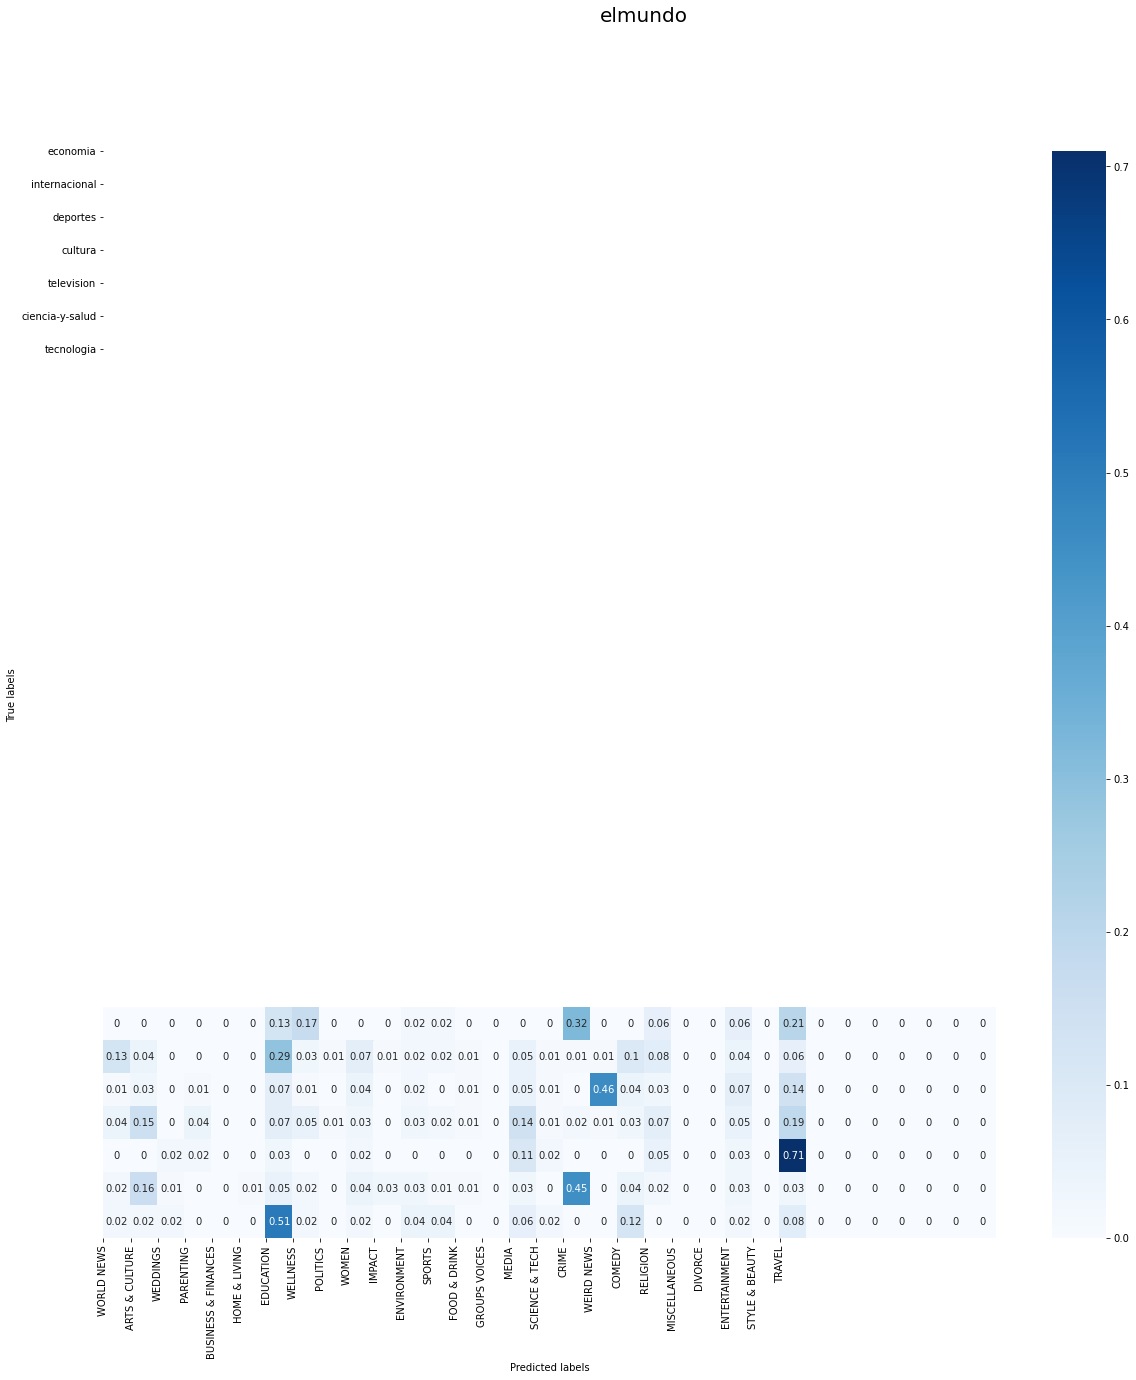

In [12]:
true_cate = [source_label[i] for i in true_labels]
pred_cate = [target_label[j] for j in pred_labels]
con_mat = confusion_matrix(true_cate,pred_cate)
con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]     # nomalization
con_mat_norm = np.around(con_mat_norm, decimals=2)
print(con_mat_norm)
# === plot ===
fig = plt.figure(figsize=(20, 20))
sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
catex = list(range(0,len(target_label),1))
catey = list(range(0,len(source_label),1))
fig.suptitle('elmundo',fontsize=20)

plt.xlabel('Predicted labels')
plt.xticks(catex,target_label)
plt.xticks(rotation=90)

plt.ylabel('True labels')
plt.yticks(catey,source_label)
plt.yticks(rotation=360)
plt.show()
# plt.savefig('./img/{}-{}-matrix.jpg'.format(init_lr,MAX_SEQ_LENGTH))